In [5]:
import pandas as pd
from home_messages_db import HomeMessagesDB

import seaborn as sns
import matplotlib.pyplot as plt


# Busiest rooms
The smartthings data contains measurements for motion sensors all throughout the house. 

One thing to analyze is how often certain locations (rooms) inside the house are frequented, and whether the behavior of the residents changes during the year.


### Fetching data from database

**Important**: Make sure that the *entire* smartthings dataset has been *raw-inserted* to your database as such:
`python3 smartthings.py --rawinsert 'sqlite:///db/myhome.db' 'data/smartthings/smartthings.*` (or any other SQLite db of your choosing).


In [6]:
MyDB = HomeMessagesDB('sqlite:///db/myhome.db')
MyDB # check if the `smartthings_RAW` table has been inserted in your database!

A HomeMessagesDB-class instance. Connected to: sqlite:///db/myhome.db 

TABLES 		COLUMNS

p1e_t1    	['time', 'imported T1', 'exported T1']
p1e_t2    	['time', 'imported T2', 'exported T2']
p1g       	['time', 'Total gas used']
smartthings_RAW	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_attic	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_bathroom	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_floor	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_garden	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_ground	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_kitchen	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_living	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']

In [7]:
statement = "SELECT name, time, value from smartthings_RAW WHERE attribute='motion'"
motion_data = MyDB.query(stmt=statement, as_df=True, rawSQL=True)
motion_data

,name,time,value
0,kitchen (move),1709381571,active
1,kitchen (stairs),1709381579,active
2,kitchen (stairs),1709381641,inactive
3,kitchen (move),1709381651,inactive
4,kitchen (move),1709420415,active
...,...,...,...
364672,living room (move),1688161699,inactive
364673,living room (move),1688161749,active
364674,bathroom (sensor eye),1688161771,inactive
364675,bathroom (sensor eye),1688162262,active


### Data Cleanup
- Converting unix time back to dates
- Creating `month` column
- Only keeping `active` columns (removing unnecessary `inactive`'s)

In [8]:
busyrooms = motion_data.copy()
busyrooms['time'] = pd.to_datetime(busyrooms['time'], unit='s')
busyrooms['month'] = busyrooms['time'].dt.month
busyrooms.drop(columns=['time'], inplace=True)
busyrooms = busyrooms[busyrooms['value'] == 'active']

busyrooms

,name,value,month
0,kitchen (move),active,3
1,kitchen (stairs),active,3
4,kitchen (move),active,3
5,living room (move),active,3
7,kitchen (stairs),active,3
...,...,...,...
364668,living room (move),active,6
364669,bathroom (sensor eye),active,6
364671,living room (move),active,6
364673,living room (move),active,6


### Grouping measurements by month
- Separate `active`-counts by `name` (location of sensor) and `month`
- Create new column `relative_activity` which is the number of activity measurements for a specific sensor location as *fraction* of the total amount of measurements *in that month*.

In [9]:
busyrooms = busyrooms.groupby(['month', 'name']).count()
busyrooms['totalcount'] = busyrooms.groupby(['month'])['value'].transform('sum')

busyrooms['relative_activity'] = busyrooms['value'] / busyrooms['totalcount']
busyrooms

value  totalcount  relative_activity
month name                                                         
1     bathroom (sensor eye)     5654       25557           0.221231
      blue room (move aeotec)   1693       25557           0.066244
      blue room (move cube)      407       25557           0.015925
      garden air (sensor)          1       25557           0.000039
      green room (move cube)     361       25557           0.014125
...                              ...         ...                ...
12    green room (move cube)     159       20024           0.007940
      kitchen (cam)             3360       20024           0.167799
      kitchen (move)            2080       20024           0.103875
      kitchen (stairs)          4292       20024           0.214343
      living room (move)        4755       20024           0.237465

[82 rows x 3 columns]

## Plotting

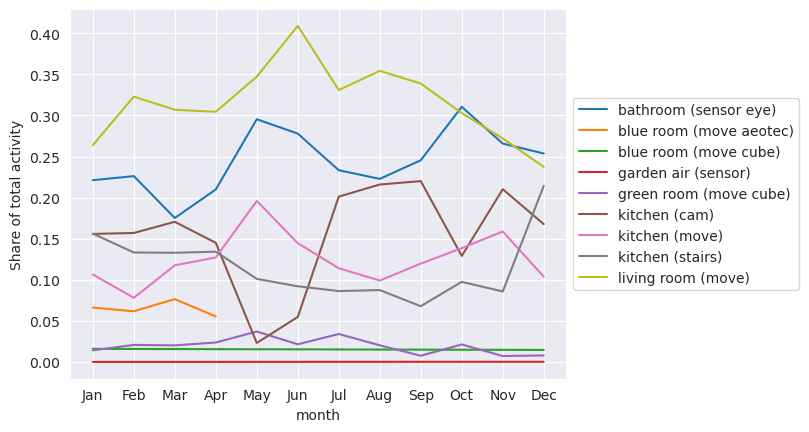

In [11]:
sns.set_style("darkgrid")
ax = sns.lineplot(data=busyrooms, x="month", y="relative_activity", hue="name")
ax.set(ylabel='Share of total activity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor="white")

plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show(ax)